# Image Classification and Adversarial Perturbations 

In this lab, we'll explore a pretrained neural network for image classification and how we can fool it with adversarial perturbation.

Before we dive in, let's discuss a helpful recipe for thinking about machine learning algorithms. In some way, every algorithm consists of:

1. **A model that produces an output from an input.** In image classification, the model takes in an image and outputs what class the image belongs to (e.g. cat or dog).

2. **A loss function that measures the quality of the model's output.** In image classification, a good output correctly classifies what's in an image (e.g. the loss is small if the model outputs cat when the image contains a cat).

3. **A method of optimizing the loss function.** In image classification (and most deep learning algorithms), the loss function is optimized via gradient descent on the model's parameters.

The loss function used for image classification---and that we'll use for finding adversarial perturbations---is cross entropy. Intuitively, cross entropy measures the difference between two distributions. In image classification, the first distribution is the true class an image belongs to and the second distribution is what class the model *predicts* the image belongs to.

Formally, the cross entropy loss between the true distribution $p$ and the predicted distribution $p'$ is

$$\sum_{i=1}^k p_i \log\left(\frac{1}{p_i'}\right)$$

where $p_i$ is an indicator random variable that is 1 if the image contains class $i$ and 0 otherwhise while $p'_i$ is the probability with which the model believes the image is in class $i$.

Because $p_i$ is zero except when the image contains $i$, we can simplify the cross entropy loss to

$$\log \left( \frac{1}{p'_j} \right)$$

where $j$ is the class that is actually in the image. We want $p'_j$ to be as large as possible so we want the cross entropy loss to be as small as possible. Hence we use gradient descent to minimize the cross entropy loss.

Training accurate deep learning models is computationally intensive. Instead of training them ourselves, we'll load a pretrained model that already works quite well.

## Using a Pretrained Model

We'll start by loading several helpful libraries.

In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

Now, we'll load the pretrained model and set it to evaluation mode. In evaluation mode, we won't keep track of the extra data needed for backpropagation.

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model = model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.9MB/s]


Let's inspect the model we just loaded. One way of understanding deep learning models is to count the number of parameters.

In [4]:
num_parameters = 0
for p in model.parameters():
  num_parameters += p.numel()
print(f'There are {num_parameters} parameters in the model!')

There are 11689512 parameters in the model!


There are more than 11 million parameters in the model! That's absolutely huge. Let's try to see what the model looks like. We can do this by printing the model.

In [5]:
# Print the model below.
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clearly, the model is very large and complicated (this is unfortunately the norm in deep learning). However, even if we don't know everything that's going on in the model, it's important to know the dimension of the input and output. The input dimension actually isn't obvious because the model uses convolutional layers. But we can check the output dimension by looking at the last printed layer. What is the output dimension?

In [6]:
# Define out_features with the appropriate dimension.
out_features = 1000

The output is a long vector. When we turn this vector into a probability distribution (using the softmax operation), we need some way of figuring out what each dimension corresponds to. Luckily, we can download and load the corresponding categories. Then, when we find which index the model thinks the image contains, we can look up the corresponding class and interpret it.

In [7]:
# from https://pytorch.org/hub/pytorch_vision_resnet/
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2023-04-21 11:50:41--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-04-21 11:50:41 (73.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Does the length of `categories` match the dimension of the model's output?

In [8]:
# Print out the length of `categories` and 
# check what class a random index corresponds to.
print(len(categories))

print(categories[22])

1000
bald eagle


Now that we have a model and a way to interpret its output, let's find an image to give it. I chose the following image.

In [9]:
image_link = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Coreopsisgigantea.jpg/1200px-Coreopsisgigantea.jpg"

Now that we have an image, let's try loading it.

In [10]:
# https://www.geeksforgeeks.org/how-to-open-an-image-from-the-url-in-pil/ 
import urllib.request
from PIL import Image
 
urllib.request.urlretrieve(image_link, 'image.png') 
image = Image.open("image.png")

We can check that it worked by inspecting the image. (Hilariously, this step can take longer than working with the image classifier.)

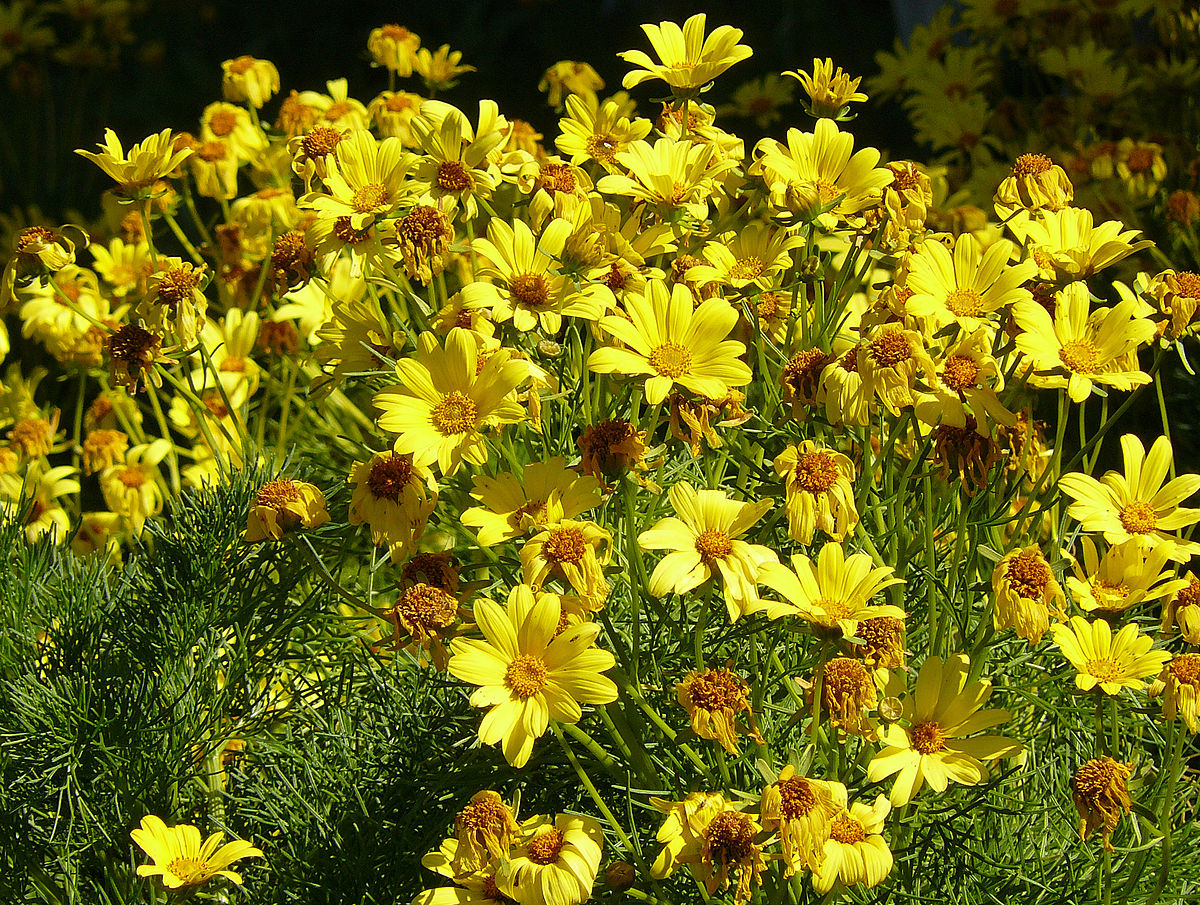

In [11]:
image.show()

Before the model can take the image as input, we'll need to do a few preprocessing steps: make sure the image is the right size (3 x 224 x 224), the right datatype (a tensor), and has normalized pixel values for numerical stability.

In [123]:
# from https://pytorch.org/hub/pytorch_vision_resnet/
normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We'll also need the following code to undo the normalization process
# when we want to visualize one of the normalized images.

# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
unnormalize = transforms.Compose([
    transforms.Normalize(mean=[0.,0.,0.], std=[1/0.229,1/0.224,1/0.225 ]),
    transforms.Normalize(mean=[-0.485,-0.456,-0.406 ], std=[1.,1.,1.]),
])

We'll start by normalizing the image with our `normalize` function and checking that its output is the right shape.

In [124]:
image_tensor = normalize(image)

print(image_tensor.shape)

torch.Size([3, 224, 224])


If we feed the image to the model now, the problem is that the model expects its input in *batches*. We can turn our single image into a singleton batch by "unsqueezing" the first dimension. Print out its shape to make sure we now have a singleton batch.

In [125]:
image_input = image_tensor.unsqueeze(dim=0)

# Print the shape of image_input.
print(image_input.shape)

torch.Size([1, 3, 224, 224])


Finally, we're ready to feed `image_input` to the model. We'll get the `output` and then `probabilities` by applying the softmax operation. Check the shape of both `output` and `probabilities`, are their shapes what you expected?

In [126]:
output = model(image_input)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Print the shape of output and probabilities.
print(output.shape)
print(probabilities.shape)

torch.Size([1, 1000])
torch.Size([1000])


To interpret the model's output, we'll take a look at the index with the highest probability. This is what class the model thinks the image contains.

In [127]:
max_prob, max_index = probabilities.max(dim=0)

print(f'The model thinks the image contains: {categories[max_index]}.')

The model thinks the image contains: daisy.


Do you agree with the model's output? It looks accurate to me!

## Fooling the Model: A Step Away from the True Class

It looks like the model works super well!  But as discussed in class, learned models aren't quite as robust as we may think. Let's explore how we can go about fooling it.

We'll fool the model by finding a very slight perturbation to an image's pixels which will look almost exactly the same to us but radically change what the model outputs.

Let's frame the adversarial perturbation in terms of our three step recipe:

1. **Model:** The model is still the pretrained image classifier. However, the parameters of the model are now small changes to the *pixels* of the input image.

2. **Loss:** The loss is still cross entropy. However, we'll try to *maximize* the loss. This will encourage the model to find a perturbation which makes the output as far from the true class as possible.

3. **Optimizer:** The optimizer is now gradient ascent. We'll take a small, single step in the pixel space that will *increase* the cross entropy loss.

We'll begin by turning the input image into a variable. We do this by using the `Variable` class and making sure the model keeps track of gradients during the backpropagation step.

In [128]:
image_variable = torch.autograd.Variable(image_input, requires_grad=True)


The target will be the index corresponding to what's in the image.

In [129]:
target = torch.LongTensor([max_index]) 

And now we'll define the criterion which is cross entropy loss.

In [130]:
criterion = torch.nn.CrossEntropyLoss()

Let's apply our three step recipe.

In [131]:
# 1. Model
# We feed the image through the model.
output = model(image_variable)

# 2. Loss
# We compute the loss between the output and the target.
loss = criterion(output, target)
# Next, we compute the gradient of the loss with respect
# to the image's pixels.
loss.backward()

# 3. Optimization
# Now we find which direction to move in. 
image_noise = torch.sign(image_variable.grad.data)
# And create a new image accordingly.
image_adversarial = image_input + 0.05 * image_noise

# Not that we use the sign function above as a simple why of "clamping" the entries in image_noise to [-1,1]. 
# If we do not do this, image_noise could have very large values in some entries, pushing the pixel values in
# image_adversarial out of range.

Now let's check what class the model thinks the image belongs to.

In [132]:
# Print out the class the model thinks that image_adversarial contains.
categories[model(image_adversarial).argmax()]

'broccoli'

Amazingly, the model thinks the image is now a different class! However, without seeing the image, it's not actually clear we've done anything impressive.

Below, we'll write a function that takes in the original image (`image_input`), the perturbation to the image (`image_noise`), the resulting image (`image_noisy`), and the model (`model`).

Then we'll output a lovely visualize of the original image, the noise, and finally the noisy image.

In [133]:
def visualize_noise(image_input, image_noise, image_noisy, model): 
  # Write code to calculate the index of the class the model thinks
  # image_input contains and the corresponding probability.
  output = model(image_input)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  input_prob, input_index = probabilities.max(dim=0)

  # Write code to calculate the index of the class the model thinks
  # image_noisy contains and the corresponding probability.
  output = model(image_noisy)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  noisy_prob, noisy_index = probabilities.max(dim=0)

  # Once input_prob, input_index, noisy_prob, and noisy_index are defined,
  # we'll plot the images with some pretty formatting.
  # Code adapted from https://github.com/weisben/adversarial-examples/blob/7a118c10e8ad5bdf826345ded237490d391136a8/Adv_Input_STL.ipynb#L493-L519
  figure, ax = plt.subplots(1,3, figsize=(14,7))

  ax[0].text(
      1.1,0.5, f"+", size=10, 
      ha="center", transform=ax[0].transAxes
  )
  ax[0].imshow(unnormalize(image_input).squeeze().permute(1, 2, 0))
  ax[0].set_title('Input Image')
  ax[0].axis('off')
  ax[0].text(
      0.5,-0.13, f"Prediction: {categories[input_index]} \n Probability: {input_prob}",
      size=10, ha="center", transform=ax[0].transAxes
  )

  ax[1].imshow(unnormalize(image_noise).squeeze().permute(1, 2, 0))
  ax[1].set_title('Noise')
  ax[1].axis('off')
  ax[1].text(1.1,0.5, " = ", size=10, ha="center", transform=ax[1].transAxes)

  ax[2].imshow(unnormalize(image_noisy).squeeze().permute(1, 2, 0))
  ax[2].set_title('Noisy Image')
  ax[2].axis('off')
  ax[2].text(
      0.5,-0.13, f"Prediction: {categories[noisy_index]} \n Probability: {noisy_prob}",
      size=10, ha="center", transform=ax[2].transAxes
  )
  plt.show()

When we call the function on the inputs we've already defined, we should get an output like the following.

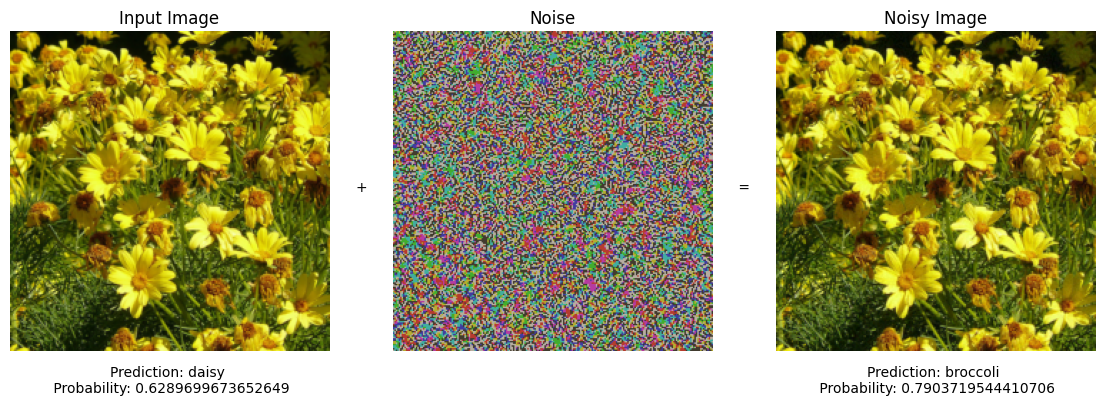

In [134]:
visualize_noise(image_input, image_noise, image_adversarial, model)

Amazingly, even though we can't tell the input image and noisy image apart, the model now thinks the image contains a different class! However, you may not be too impressed because the new class may be somewhat similar to the old class.

## Fooling the Model: A Step Towards the Wrong Class

Before, we found a pixel perturbation that moved us *away* from the right class. Could we instead move towards a *wrong* class of our choice? Yes we can!

The three step recipe is now subtly different:

1. **Model.** The model is still the image classifier and the parameters are still pixel perturbations.

2. **Loss.** The loss is still cross entropy. However, the target distribution is now the *wrong* class. And, to make the perturbed class as similar to the wrong class, we'll now *minimize* the cross entropy loss.

3. **Optimizer.** We'll again take a single step but in the direction of the negative gradient so we can minimize cross entropy loss.

Let's choose a wrong class: say, pineapple. (Of course, we have to make sure that `categories` contains the wrong class we want.)

In [135]:
# Using the prior code as a template, define target
# so that its index corresponds to the wrong class we chose.
target = torch.LongTensor([categories.index('pineapple')]) 

We will now try to find a perturbation that makes the model think the image is of a pineapple. Using our prior code as a template, start by applying the three step recipe we just discussed.

In [136]:
# 1. Model
# We feed the image through the model.
output = model(image_variable)

# 2. Loss
# We compute the loss between the output and the target.
loss = criterion(output, target)
# Next, we compute the gradient of the loss with respect
# to the image's pixels.
loss.backward()

# 3. Optimization
# Now we find which direction to move in. 
image_noise = torch.sign(image_variable.grad.data)
# And create a new image accordingly (remember to *minimize*).
image_adversarial = image_input - 0.05 * image_noise

Now let's use our `visualize_noise` function to see whether the adversarial noise worked. 

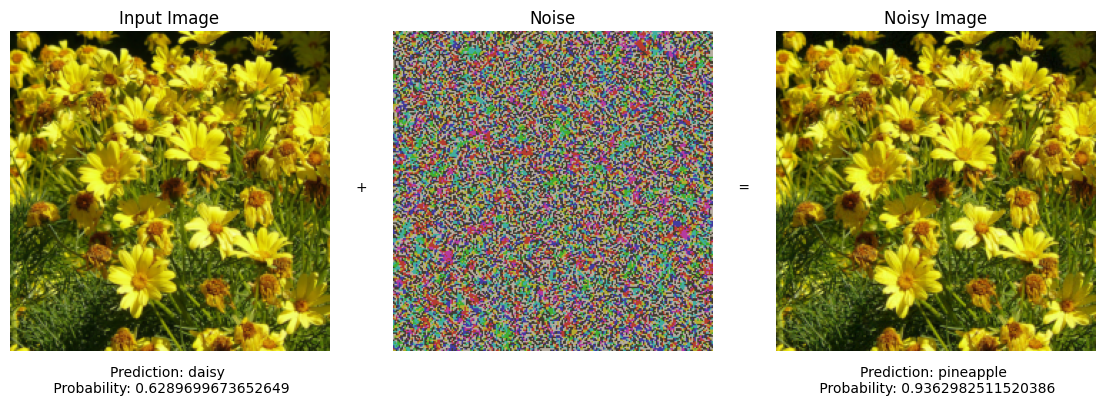

In [137]:
visualize_noise(image_input, image_noise, image_adversarial, model)

Sure enough, we fooled the model into thinking the image is a pineapple! Somewhat encouragingly, it's actually slightly challenging to find a wrong class which we can use to fool the model in one step.

## The Effect of Random Noise

So far, we've seen how small amounts of noise can change the model's output. It may be reasonable to conclude that *all* noise has this effect. Fortunately, if we generate the noise randomly, we actually don't see changes most of the time.

We'll prove that by example next. Use `torch.randint` and some clever adjustments to generate a tensor of random $\pm 1$ that is the same shape as `image_noise`.

In [138]:
# Define a random +1/-1 tensor of dimension 1x3x224x224.
image_random_noise = (torch.randint(2, size=image_noise.shape)*2-1).float()

Now define `image_noisy` in terms of `image_input`, `image_noise`, and a noise level of your choice.

In [139]:
# Define image_noisy.
# Note: since it's random, it doesn't matter whether 
# we add or subtract the noise.
image_noisy = image_input + .05 * image_random_noise

Then, when we use `visualize_noise` to inspect its effect, we find that the random noise actually didn't change the model's output much.

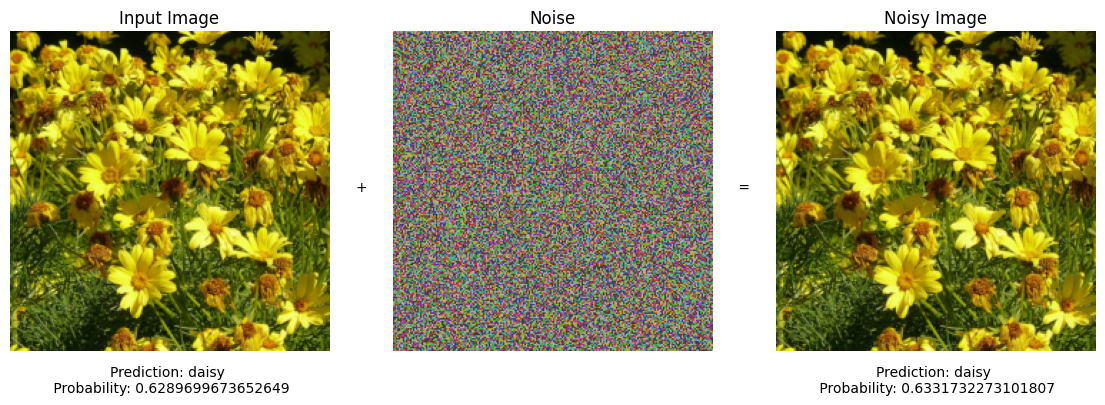

In [140]:
visualize_noise(image_input, image_random_noise, image_noisy, model)

## Encore

The final step of this lab is to do it again but with your own image from the internet and your own *wrong* class. Modify the above code so that `image_link` points to your own image, the noise level is chosen appropriately so the perturbations work, and you find a wrong class that you can use to fool the model.